# PMAP Medication Info Feature Engineering
Created: January 17, 2023\
*Last modified: January 29, 2023*

This notebook generates two features from medication data:
1. Binary flags for the administration of certain drug classes, as defined by each file in the medication_class_names folder. 
2. Average dosing for medications, based on csv inputs with conversion factors for each possible dose unit, desired target doses, and names/brand names of drugs.

Author: Vina Ro

In [1]:
# Import packages
import numpy as np
import pandas as pd
import time as time
import seaborn as sns
import missingno as msno
import os
import glob
from time import time
from pathlib import Path
import inspect as insp
import matplotlib.pyplot as plt

In [2]:
# Set filepath
file_path = Path('PMAP_Meds.ipynb').resolve()
data_path = file_path.parent.parent.parent.parent.parent.joinpath('Data/jbergma8/IRB_271579_Faraday/IRB-271579-v3-DEID-220607-no-ptsd')

In [4]:
# Import data
med_admin          = pd.read_csv(data_path / 'med_admin.csv',
                                 usecols = ['osler_sid','pat_enc_csn_sid','medication_name','taken_time','mar_action', 'route', 'sig','dose_unit'],
                                 parse_dates = ['taken_time'])
#med_admin_updated  = pd.read_csv(data_path / 'med_admin_updated.csv',
#                                 usecols = ['osler_sid','pat_enc_csn_sid','medication_name','taken_time','mar_action', 'route', 'sig','dose_unit'],
#                                 parse_dates = ['taken_time'])
#med_orders         = pd.read_csv(data_path / 'med_orders.csv')
weights            = pd.read_csv('weights.csv')
CHF_hosp_icu_stays = pd.read_csv('CHF_hosp_icu_stays.csv',parse_dates=['hosp_admsn_time','hosp_disch_time'])

## Data Cleaning

In [5]:
# Remove admins where it wasn't a real admin
keep_actions = ['Given','Rate Verify','New Bag','Handoff','Rate/Dose Verify','Rate Change','Stopped']
med_admin = med_admin[med_admin.mar_action.isin(keep_actions)]

# Extract medication data for our cohort
CHF_hosp_med_admin = pd.merge(left = CHF_hosp_icu_stays[['osler_sid','pat_enc_csn_sid','hosp_admsn_time','hosp_disch_time']],
                              right = med_admin,
                              how = 'left',
                              on = ['osler_sid','pat_enc_csn_sid'])

# Taken medication time needs to be within hospital admission period
CHF_hosp_med_admin = CHF_hosp_med_admin[CHF_hosp_med_admin.taken_time.between(CHF_hosp_med_admin.hosp_admsn_time, CHF_hosp_med_admin.hosp_disch_time)]
CHF_hosp_med_admin['medication_name'] = CHF_hosp_med_admin['medication_name'].str.lower()
CHF_hosp_med_admin = CHF_hosp_med_admin.sort_values(['osler_sid','hosp_admsn_time','taken_time'])

# Get list of filenames in specified folder
all_drug_classes = sorted(glob.glob("./medication_class_name/*"))
all_drug_doses = sorted(glob.glob("./medication_names_dose/*"))

### Investigate relationship between medication names and routes to fill in missing route values

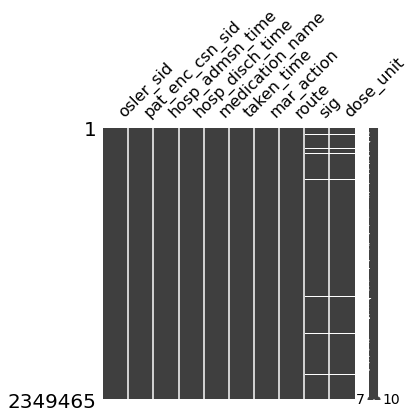

In [92]:
msno.matrix(CHF_hosp_med_admin, figsize = (5,5))
plt.show()

In [119]:
med_dict = {}
for i in range(len(all_drug_doses)):
    drug_name = all_drug_doses[i].split('/')[-1]
    drug_name = drug_name.split('.')[0]
    drug = pd.read_csv('./medication_names_dose/' + drug_name + '.csv', squeeze = True)
    druglist = drug.str.lower().str.strip().to_list()
    # print(drug_name)
    admins = CHF_hosp_med_admin[CHF_hosp_med_admin['medication_name'].str.contains('|'.join(druglist))]
    med_dict[drug_name] = [len(admins[admins.route.isnull()]), len(admins)]

In [132]:
df = pd.DataFrame.from_dict(med_dict, orient = 'index', columns = ['missing count', 'total count'])
df['prop (%)'] = df['missing count'] / df['total count']*100
df.sort_values('prop (%)', ascending = False)

,missing count,total count,prop (%)
mannitol,12,90,13.333333
etomidate,29,269,10.780669
phenylephrine,259,5154,5.025223
midazolam,198,10065,1.967213
isoproterenol,4,270,1.481481
nitroprusside,182,13528,1.345358
nitroglycerin,182,13528,1.345358
lorazepam,84,6631,1.266777
dopamine,90,7450,1.208054
vasopressin,167,15212,1.097818


We can see from the above that the top 3 medications with most missing values are **mannitol**, **etomidate**, and **phenylephrine**. \
Hence we'll start with filling the missing values for these three meds in the function by making a dictionary that maps missing values.

In [137]:
top_3_drugs = ['mannitol','etomidate','phenylephrine']
for i in range(len(top_3_drugs)):
    med_dict = {}
    drug_name = top_3_drugs[i]
    print(drug_name + '-----------------')
    drug = pd.read_csv('./medication_names_dose/' + drug_name + '.csv', squeeze = True)
    druglist = drug.str.lower().str.strip().to_list()
    admins = CHF_hosp_med_admin[CHF_hosp_med_admin['medication_name'].str.contains('|'.join(druglist))]
    for x in admins.route.unique():
        med_dict[x] = list(admins[admins.route == x]['medication_name'].unique())
    print(med_dict)
    print('med names w missing route values:')
    print(list(admins[admins.route.isnull()]['medication_name'].unique()))

mannitol-----------------
{'Intravenous': ['mannitol 25 % intravenous solution', 'zoledronic acid 4 mg/100 ml-mannitol-0.9 % nacl intravenous piggyback', 'mannitol 20 % intravenous solution'], 'Extracorporeal': ['mannitol 25 % intravenous solution'], nan: []}
med names w missing route values:
['mannitol 25 % intravenous solution']
etomidate-----------------
{'Intravenous': ['etomidate 2 mg/ml intravenous solution'], nan: [], 'Intraosseous': ['etomidate 2 mg/ml intravenous solution']}
med names w missing route values:
['etomidate 2 mg/ml intravenous solution']
phenylephrine-----------------
{'Intravenous': ['phenylephrine 1 mg/10 ml (100 mcg/ml) in 0.9 % sod.chloride iv syringe', 'phenylephrine 1 mg/10 ml (100 mcg/ml) swfi syringe', 'phenylephrine 10 mg/ml injection solution', 'phenylephrine 40 mcg/ml in ns (jhh ped)', 'phenylephrine infusion 20 mg/250 ml ns (jhh)'], nan: [], 'Continuous IV Infusion': ['phenylephrine infusion 20 mg/250 ml ns (jhh)', 'phenylephrine infusion 40 mg/250 ml 

By printing out all the medication names whose route values are missing, we can see that they all map to a certain routes for other entries with an identical medication name.

## Functions

In [6]:
def convert_units(convs, val, unit, weight, minutes):
    '''
    This function takes in unit conversion dictionary, value amount, dose unit, closest weight in kg, and time length of admin
    '''
    conv_factor = convs.get('conv_factor').get(unit)
    multiply_time = convs.get('multiply_min').get(unit)

    # If desired unit divides by weight.
    divide_kg = convs.get('divide_kg')
    if divide_kg == None:
        divide_kg = 0
    else :
        divide_kg = divide_kg.get(unit)

    # If desired unit is not divided by weight. 
    multiply_kg = convs.get('multiply_kg')
    if multiply_kg == None:
        multiply_kg = 0
    else :
        multiply_kg = multiply_kg.get(unit) 

    # Apply conversion factors and adjustments.
    try:
        val = val * conv_factor
    except:
        print("Unit: ", unit)
        print(type(val))
        print(val)
        print(type(conv_factor))
        print(conv_factor)

    if divide_kg == 1: # Needs to divide by patient weight
        val = val / weight
    if multiply_kg == 1:
        val = val * weight # Needs to multiply by patient weight
    if multiply_time == 1:
        val = val * multiply_time
    return val

In [7]:
def get_min_to_next(curr_pat_id, next_pat_id, curr_enc_id, next_enc_id, taken_time, next_taken_time, hosp_disch_time):
    '''
    This function finds the time to the next admin, or the end of the ICU stay if it's the last admin of the encounter. 
    '''
    # Check if next admin is same encounter or not. 
    if (curr_pat_id == next_pat_id) & (curr_enc_id == next_enc_id):
        return (next_taken_time - taken_time).total_seconds()/60
    else:
        return(hosp_disch_time - taken_time).total_seconds()/60

In [8]:
def get_feat(df_hosp_orig, df_meds):
    '''
    This function adds columns to the original dataframe with binary flags for each medication class for each hospital stay.
    '''
    df_hosp = df_hosp_orig.copy()
    for i in range(len(all_drugs_classes)):
        drug = pd.read_csv(all_drugs_classes[i])
        drug_name = drug.columns.values[0]
        drug_list = list(drug[drug_name].str.lower())

        # Only keep rows where sugars are not being used as a solvent
        if drug_name == 'Sugars':
            df_meds = df_meds[~df_meds['medication_name'].str.contains('piggyback|in dextrose|in 5% dextrose')]

        # Subset dataframe for specific medications in the current medication class
        temp = df_meds[df_meds['medication_name'].str.contains('|'.join(drug_list), na = False)]
        df_hosp[drug_name] = df_hosp['pat_enc_csn_sid'].isin(temp.pat_enc_csn_sid).astype(int)
    return df_hosp

In [9]:
def get_feat_wRoute(df_hosp_orig, df_meds):
    '''
    This function adds columns to the original dataframe with binary flags for each medication class and categorized to different routes for each hospital stay.
    '''
    df_hosp = df_hosp_orig.copy()
    for i in range(len(all_drugs_classes)):
        drug = pd.read_csv(all_drugs_classes[i])
        drug_name = drug.columns.values[0]
        drug_list = list(drug[drug_name].str.lower())

        # Only keep rows where sugars are not being used as a solvent
        if drug_name == 'Sugars':
            df_meds = df_meds[~df_meds['medication_name'].str.contains('piggyback|in dextrose|in 5% dextrose')]

        # Subset dataframe for specific medications in the current medication class
        temp = df_meds[df_meds['medication_name'].str.contains('|'.join(drug_list), na = False)]

        for routes in temp.route.unique():
            feat = temp[temp.route == routes]['pat_enc_csn_sid'].unique()
            df_hosp[drug_name + '_{}'.format(routes)] = df_hosp['pat_enc_csn_sid'].isin(feat).astype(int)
    return df_hosp

In [122]:
def get_drug_dosage_feat(drug_name, df_cohort):
    
    print(drug_name)
    inp = df_cohort.copy()
    result = CHF_hosp_icu_stays[['osler_sid','pat_enc_csn_sid']].copy()

    #admins = CHF_hosp_med_admin.copy()
    
    drug = pd.read_csv('./medication_names_dose/' + drug_name + '.csv', squeeze = True)
    druglist = drug.str.lower().str.strip().to_list()
    
    # Get hosp length of stay (LOS) in minutes.
    inp['LOS'] = (inp['hosp_disch_time'] - inp['hosp_admsn_time']).dt.total_seconds()/60 # in minutes

    admins = CHF_hosp_med_admin[CHF_hosp_med_admin['medication_name'].str.contains('|'.join(druglist))]

    if admins.shape[0] == 0:
        print(drug_name + ' has no admins')
        return 'no admins'

    admins = admins.dropna(subset=['sig','dose_unit']).copy()
    # Drop admins that have "mL" as dose unit. 
    admins = admins[~(admins['dose_unit']=='mL')].copy()

    # Get minutes between admins.
    admins = admins.merge(inp[['osler_sid','pat_enc_csn_sid','LOS']], on=['osler_sid','pat_enc_csn_sid'], how='left')

    if(drug_name in(['ketamine'])):
        admins['dose_unit'] = admins['dose_unit'].str.replace(' PCA', '')

    # Find correct dose units. 
    med_unit = pd.read_csv('./medication_dose_convs/med_units.csv')
    med_unit.set_index('drugname', inplace=True)

    #Get dose units string.
    target_unit = med_unit.loc[drug_name,'unit']
    target_unit_str = ''.join(target_unit.split('/')[0:-1]) #mcg

    unit_convs = pd.read_csv('./medication_dose_convs/all_med_doses_units_'+ target_unit_str + '.csv')
    unit_convs.set_index('index', inplace=True)
    unit_convs = unit_convs.to_dict()

    # Do the above for medications but not specified by given routes
    admins['next_taken_time'] = admins['taken_time'].shift(periods = -1)
    admins['next_osler_sid'] = admins['osler_sid'].shift(periods = -1)
    admins['next_pat_enc_csn_sid'] = admins['pat_enc_csn_sid'].shift(periods = -1)

    admins['min_to_next'] = admins.apply(lambda row: get_min_to_next(row['osler_sid'], row['next_osler_sid'], row['pat_enc_csn_sid'], row['next_pat_enc_csn_sid'],
                                                                     row['taken_time'], row['next_taken_time'], row['hosp_disch_time']), axis = 1)
    # Get weights (already extracted from most recent)
    admins = pd.merge(left = admins, right = weights , on = ['osler_sid','pat_enc_csn_sid'])

    admins['dose'] = admins.apply(lambda row: convert_units(unit_convs, row['sig'], row['dose_unit'],row['weight'], row['min_to_next']), axis = 1)
    admins['dose_by_time'] = admins['dose'] * admins['min_to_next']
    admins = admins.groupby(['osler_sid', 'pat_enc_csn_sid'], as_index = False).sum()
    admins['average_dose_' + drug_name ] = admins['dose_by_time'] / admins['LOS']
    result = result.merge(admins[['osler_sid','pat_enc_csn_sid','average_dose_' + drug_name]], on = ['osler_sid','pat_enc_csn_sid'], how = 'left')
    
    return result

In [125]:
def get_drug_dosage_featwRoute(drug_name, df_cohort):
    
    print(drug_name)
    inp = df_cohort.copy()
    result = CHF_hosp_icu_stays[['osler_sid','pat_enc_csn_sid']].copy()

    #admins = CHF_hosp_med_admin.copy()
    
    drug = pd.read_csv('./medication_names_dose/' + drug_name + '.csv', squeeze = True)
    druglist = drug.str.lower().str.strip().to_list()
    
    # Get hosp length of stay (LOS) in minutes.
    inp['LOS'] = (inp['hosp_disch_time'] - inp['hosp_admsn_time']).dt.total_seconds()/60 # in minutes

    admins = CHF_hosp_med_admin[CHF_hosp_med_admin['medication_name'].str.contains('|'.join(druglist))]

    if admins.shape[0] == 0:
        print(drug_name + ' has no admins')
        return 'no admins'

    admins = admins.dropna(subset=['sig','dose_unit','route']).copy()
    # Drop admins that have "mL" as dose unit. 
    admins = admins[~(admins['dose_unit']=='mL')].copy()

    # Get minutes between admins.
    admins = admins.merge(inp[['osler_sid','pat_enc_csn_sid','LOS']], on=['osler_sid','pat_enc_csn_sid'], how='left')

    if(drug_name in(['ketamine'])):
        admins['dose_unit'] = admins['dose_unit'].str.replace(' PCA', '')

    # Find correct dose units. 
    med_unit = pd.read_csv('./medication_dose_convs/med_units.csv')

    # Set index
    med_unit.set_index('drugname', inplace=True)

    #Get dose units string.
    target_unit = med_unit.loc[drug_name,'unit']
    target_unit_str = ''.join(target_unit.split('/')[0:-1]) #mcg

    unit_convs = pd.read_csv('./medication_dose_convs/all_med_doses_units_'+ target_unit_str + '.csv')
    unit_convs.set_index('index', inplace=True)
    unit_convs = unit_convs.to_dict()
    
    for rte in admins['route'].unique():
        # For each route, get the subset of admins
        admins_rte = admins[admins['route'] == rte].copy()
        
        # Perform shift operations to get all med administrations in chronological order
        admins_rte['next_taken_time'] = admins_rte['taken_time'].shift(periods = -1)
        admins_rte['next_osler_sid'] = admins_rte['osler_sid'].shift(periods = -1)
        admins_rte['next_pat_enc_csn_sid'] = admins_rte['pat_enc_csn_sid'].shift(periods=-1)

        # check if the route has any administrations in the timeframe
        if admins_rte.shape[0] == 0:
            #print(drug_name)
            #print(rte)
            print(drug_name + ' ' + rte + ' has no admins in this timeframe')
            continue

        # Find mins to next medication administration
        admins_rte['min_to_next'] = admins_rte.apply(lambda row: get_min_to_next(row['osler_sid'], row['next_osler_sid'], row['pat_enc_csn_sid'], row['next_pat_enc_csn_sid'],
                                                                                 row['taken_time'], row['next_taken_time'], row['hosp_disch_time']), axis = 1)

        admins_rte = pd.merge(left = admins_rte, right = weights , on = ['osler_sid','pat_enc_csn_sid'])

        # Convert units of medication (sig -> dose)
        admins_rte['dose'] = admins_rte.apply(lambda row: convert_units(unit_convs, row['sig'], row['dose_unit'],row['weight'], row['min_to_next']), axis = 1)

        # For each admin, multiply the dose per weight by time. 
        admins_rte['dose_by_time'] = admins_rte['dose'] * admins_rte['min_to_next']

        # Add up all doses of those for the whole ICU stay, then divide by length of ICU stay to get average dose/weight over whole stay.
        admins_rte = admins_rte.groupby(['osler_sid', 'pat_enc_csn_sid'], as_index = False).sum()
        admins_rte['average_dose_' + drug_name + '_' + rte] = admins_rte['dose_by_time'] / admins_rte['LOS']
        result = result.merge(admins_rte[['osler_sid','pat_enc_csn_sid','average_dose_' + drug_name + '_' + rte]], on = ['osler_sid','pat_enc_csn_sid'], how = 'outer')
    
    return result

## Main

In [126]:
# Generate dosage features
merged = CHF_hosp_icu_stays.copy()
for i in range(len(all_drug_doses)):
    # Get just drug name.
    drug_name = all_drug_doses[i].split('/')[-1]
    drug_name = drug_name.split('.')[0]
    temp = get_drug_dosage_featwRoute(drug_name, CHF_hosp_icu_stays)
    if isinstance(temp, pd.DataFrame) == False:
            continue
    merged = pd.merge(left = merged, right = temp, on = ['osler_sid','pat_enc_csn_sid'], how = 'left')

betamethasone
cortisone
dexamethasone
dexmedetomidine
diazepam
dobutamine
dopamine
epinephrine
etomidate
fentanyl
fosphenytoin
gabapentin
hydralazine
hydromorphone
isoproterenol
ketamine
labetalol
lacosamide
levetiracetam
lorazepam
mannitol
methylprednisolone
midazolam
milrinone
morphine
nesiritide
nicardipine
nitroglycerin
nitroprusside
norepinephrine
oxycodone
phenobarbital
phenylephrine
phenytoin
prednisone
pregabalin
propofol
remifentanil
riociguat
triamcinolone
valproate
vasopressin


In [134]:
merged.mean()

<ipython-input-134-9b2bf1002f81>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  merged.mean()


pat_enc_csn_sid                                               1.000335e+09
labels                                                        1.530749e-01
average_dose_betamethasone_Intramuscular                      6.867531e+03
average_dose_betamethasone_Topical                            0.000000e+00
average_dose_cortisone_Oral                                   6.064967e+02
                                                                  ...     
average_dose_vasopressin_Continuous IV Infusion               7.810882e-04
average_dose_vasopressin_Intravenous                          1.959268e-01
average_dose_vasopressin_Intravenous (Continuous Infusion)    4.946103e+00
average_dose_vasopressin_Subcutaneous                         1.383933e+00
average_dose_vasopressin_central venous line infusion         1.148624e-02
Length: 218, dtype: float64

In [43]:
drug_name = 'cortisone'
inp = CHF_hosp_icu_stays.copy()
result = CHF_hosp_icu_stays[['osler_sid','pat_enc_csn_sid']].copy()

admins = CHF_hosp_med_admin.copy()

drug = pd.read_csv('./medication_names_dose/' + drug_name + '.csv', squeeze = True)
druglist = drug.str.lower().str.strip().to_list()

# Get hosp length of stay (LOS) in minutes.
inp['LOS'] = (inp['hosp_disch_time'] - inp['hosp_admsn_time']).dt.total_seconds()/60 # in minutes

admins = CHF_hosp_med_admin[CHF_hosp_med_admin['medication_name'].str.contains('|'.join(druglist))]

if admins.shape[0] == 0:
    print(drug_name + ' has no admins')
#     return 'no admins'

admins = admins.dropna(subset=['sig','dose_unit']).copy()
# Drop admins that have "mL" as dose unit. 
admins = admins[~(admins['dose_unit']=='mL')].copy()

# Get minutes between admins.
admins = admins.merge(inp[['osler_sid','pat_enc_csn_sid','LOS']], on=['osler_sid','pat_enc_csn_sid'], how='left')

if(drug_name in(['ketamine'])):
    admins['dose_unit'] = admins['dose_unit'].str.replace(' PCA', '')

# Find correct dose units. 
med_unit = pd.read_csv('./medication_dose_convs/med_units.csv')

# Set index
med_unit.set_index('drugname', inplace=True)

#Get dose units string.
target_unit = med_unit.loc[drug_name,'unit']
target_unit_str = ''.join(target_unit.split('/')[0:-1]) #mcg

unit_convs = pd.read_csv('./medication_dose_convs/all_med_doses_units_'+ target_unit_str + '.csv')
unit_convs.set_index('index', inplace=True)
unit_convs = unit_convs.to_dict()

for rte in admins['route'].unique():
    # For each route, get the subset of admins
    admins_rte = admins[admins['route'] == rte].copy()

    # Perform shift operations to get all med administrations in chronological order
    admins_rte['next_taken_time'] = admins_rte['taken_time'].shift(periods = -1)
    admins_rte['next_osler_sid'] = admins_rte['osler_sid'].shift(periods = -1)
    admins_rte['next_pat_enc_csn_sid'] = admins_rte['pat_enc_csn_sid'].shift(periods=-1)

    # check if the route has any administrations in the timeframe
    if admins_rte.shape[0] == 0:
        print(drug_name)
        print(rte)
        print(drug_name + ' ' + rte + ' has no admins in this timeframe')

cortisone
nan


TypeError: can only concatenate str (not "float") to str

In [47]:
admins[admins.route.isnull()]['medication_name'].unique()

array(['hydrocortisone sod succinate (pf) 100 mg/2 ml solution for injection'],
      dtype=object)

In [45]:
admins.route.unique()

array(['Oral', 'Intravenous', 'Rectal', 'Topical', 'Left Ear',
       'Right Ear', nan, 'J-Tube', 'Per NG Tube', 'Both Ears', 'G-Tube',
       'PEG Tube'], dtype=object)

In [ ]:
intra

In [226]:
medication_rte_features = get_feat_wRoute(CHF_hosp_icu_stays, CHF_hosp_med_admin)

/home/idies/miniconda3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [227]:
medication_features = get_feat(CHF_hosp_icu_stays, CHF_hosp_med_admin)

In [230]:
medication_rte_features.to_csv('medication_rte_features.csv', index = False)
medication_features.to_csv('medication_features.csv', index = False)

# Data Visualization

## Medication Class Prevalence in CHF Hospital Stays

In [368]:
df = pd.DataFrame()
df['meds'] = medication_features.columns[7:]
df['count'] = medication_features.iloc[:, 7:].sum().values/4488*100
df = df.sort_values('count')

sns.set_theme()
plt.figure(figsize = (18,18))
plt.barh(df['meds'],df['count'])
plt.title('Medication Class Prevalence in CHF Hospital Stays (N = {})'.format(len(CHF_hosp_icu_stays)), fontsize = 18)
plt.xlim([0, 102])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('prevalence (%)',fontsize = 16)
plt.show()

NameError: name 'medication_features' is not defined

## Medication Class Prevalence in CHF Hospital Stays (Zoomed in on prevalence > 80 %)

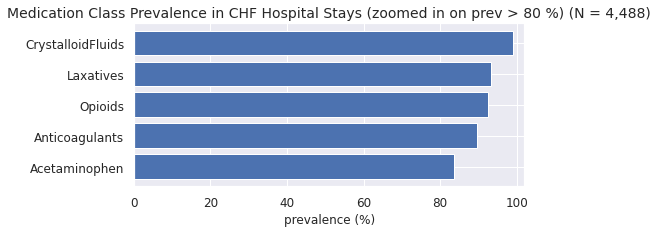

In [268]:
df = df[df['count'] > 80]

plt.figure(figsize = (7,3))
plt.barh(df['meds'],df['count'])
plt.title('Medication Class Prevalence in CHF Hospital Stays (zoomed in on prev > 80 %) (N = 4,488)', fontsize = 14)
plt.xlim([0, 102])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('prevalence (%)',fontsize = 12)
plt.show()

## Medication Class Prevalence in CHF Hospital Stays for both labels

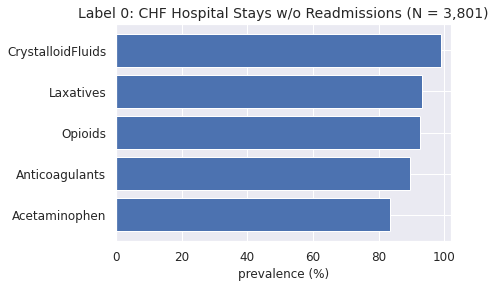

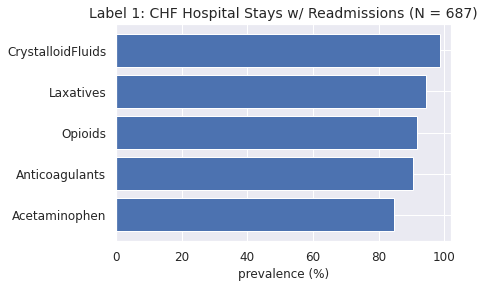

In [280]:
temp0 = medication_features[medication_features.labels == 0]
temp1 = medication_features[medication_features.labels == 1]
df0 = pd.DataFrame()
df1 = pd.DataFrame()
df0['meds'] = temp0.columns[7:]
df0['count'] = temp0.iloc[:, 7:].sum().values/temp0.shape[0]*100
df1['meds'] = temp1.columns[7:]
df1['count'] = temp1.iloc[:, 7:].sum().values/temp1.shape[0]*100
df0 = df0.sort_values('count')
df1 = df1.sort_values('count')

#plt.figure(figsize = (18,18))
plt.barh(df0.iloc[-5:, :]['meds'],df0.iloc[-5:, :]['count'])
plt.title('Label 0: CHF Hospital Stays w/o Readmissions (N = 3,801)', fontsize = 14)
plt.xlim([0, 102])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('prevalence (%)',fontsize = 12)
plt.show()

#plt.figure(figsize = (18,18))
plt.barh(df1.iloc[-5:, :]['meds'],df1.iloc[-5:, :]['count'])
plt.title('Label 1: CHF Hospital Stays w/ Readmissions (N = 687)', fontsize = 14)
plt.xlim([0, 102])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('prevalence (%)',fontsize = 12)
plt.show()


In [276]:
df1.iloc[-5:, :]

,meds,count
0,Acetaminophen,84.570597
5,Anticoagulants,90.393013
35,Opioids,91.848617
27,Laxatives,94.468705
19,CrystalloidFluids,98.835517


## Save off all medication dose units in our dataset

In [28]:
# Drop admins missing dose info. 
med_admin = med_admin.dropna(subset=['dose_unit'])

# Save off all dose units. 
admins = med_admin.dose_unit.value_counts().reset_index()
admins['prop'] = admins['dose_unit'] / admins['dose_unit'].sum()

admins.to_csv('all_med_doses_units_raw.csv', index=False)

<AxesSubplot:>

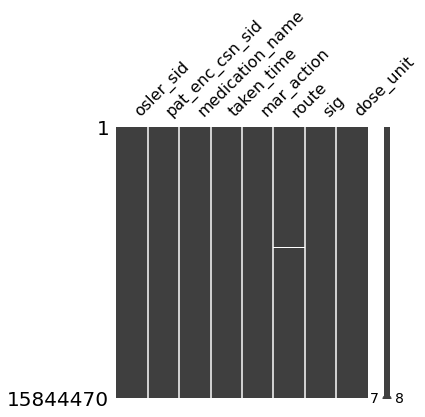

In [29]:
msno.matrix(med_admin, figsize = (5,5))